## Definitions
   * mu_t is the predicted next frame via an autoreggressive model, modeled by a hidden state variable h
   * This is corrected by y(t)_0 which is an additive correction such that we predict (x(t) - mu(t))/sigma, where sigma is a weighted hyperparameter
   * The diffusion model will then predict the x_t at runtime by taking the autoreggressive mu, and the diffusion models prediction for the next residual correction, and will sample these together to correct the model.

# Takeaways
   * The forward process is just an autoreggressive model GRU U-net
   * The goal of the diffusion model is purely to correct the Autoreggressive GRU U-net.
   * From when we generate, we will input these corrections, to create to iteratively correct the time sequence model as we sample forward

In [2]:
import ResBlock_ConvGRU_Downsample
import UpSampleBlock
import MovingMNIST
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import MovingMNIST
from torchsummary import summary
import convgru

# GRU U-Net

Our first step is to create a model of a GRU U-net, this will allow us to do an autoregressive generation of our data. This should work fine to model a general idea of the videos flow; however, will fail to do anything much deeper

In [3]:
import torch.nn as nn

class AutoregressiveUNET(nn.Module):
    def __init__(self, channels = (1, 32, 64, 128, 256, 512) ):
        super(AutoregressiveUNET, self).__init__()
        
        self.channels = channels
        self.Down = []
        self.Up = []
        
        in_channels = channels[0]
        out_channels = channels[1]
        
        self.head_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        
        
        for i in range(1, len(channels)-1):
            self.Down.append(ResBlock_ConvGRU_Downsample.ResBlock_ConvGRU_Downsample(channels[i], channels[i+1]))
        
        for i in range(1, len(channels)-1):
            self.Up.append(UpSampleBlock.ResBlockUpsample(channels[i+1], channels[i]))
            
        self.tail_block = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, in_channels, 3, 1, 1),
            nn.ReLU()
        )
                      
        self.DownSample = torch.nn.ModuleList(self.Down)
        self.UpSample = torch.nn.ModuleList(self.Up)
        
    def forward(self, x, hidden = None):
                      
        if hidden == None:
            hidden = [None]*len(self.channels)
        residual = [0]*len(self.channels)
        h=[0]*len(self.channels)
        
        x = self.head_block(x)
        
        for i in range(len(self.channels)-2):
            x, h[i], residual[i] = self.DownSample[i](x,hidden[i])
                      
        for i in reversed(range(len(self.channels)-2)):
            x = self.UpSample[i](x, residual[i])
        
        x = self.tail_block(x)
        
            
        return x, h
 

In [4]:
summary(AutoregressiveUNET(), (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,928
             ReLU-11           [-1, 64, 64, 64]               0
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          73,792
          Sigmoid-14           [-1, 64,

# Data Loader

We will be using the MovingMNIST dataset to try to train and test our data, we will use a dataloader found on Github.

In [5]:
data_loader = MovingMNIST.MovingMNISTDataset('Data/mnist_test_seq.npy')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
images = next(iter(data_loader))
import time


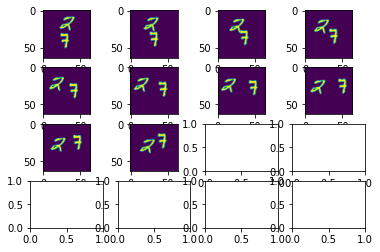

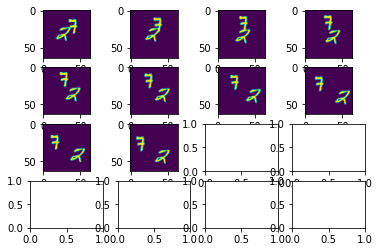

In [8]:
#state_dict = torch.load('./Models/February27,2023-05')
#model = AutoregressiveUNET()
#model.load_state_dict(state_dict)



vid = np.array( np.array(images[0])[:, 0, : :] )
res = np.array( np.array(images[1])[:, 0, : :] )


fig, axs = plt.subplots(4,4)

for i in range(10):
    axs[int(i/4), i%4].imshow(vid[i, :, :])
    
fig, axs = plt.subplots(4,4)
for i in range(10):
    axs[int(i/4), i%4].imshow(res[i, :, :])
    



# Training

Now that we have our model and our data we can train out models

In [11]:
loss_fn = torch.nn.MSELoss() 
state_dict = torch.load('./Models/MostRecent')
model = AutoregressiveUNET()
model.load_state_dict(state_dict)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [16]:
torch.autograd.set_detect_anomaly(True)
import datetime

def predict(prev, pred):
    
    hidden = None
    output = None

    for image in prev:
            # forward compute the image
        hidden_prev = hidden
        output, hidden = model(image, hidden)
        
        
    results = torch.zeros_like(prev)
    results[0,: ,:, :, :] = output
        
    for i in range(9):
        results[i+1, :,:, :, :], hidden = model(pred[i, :,:, :, :], hidden)
        
    return results


def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    batch_size = 32


    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
    PREV = torch.zeros(10, batch_size, 1, 64, 64)
    PRED = torch.zeros(10, batch_size, 1, 64, 64)
    
    batch = 0
    
    for i, data in enumerate(data_loader):
        
        # given prev, predict pred
        
        
        
        
        if ( not (i % batch_size == batch_size-1)):
            print(i%batch_size, end = '\r')
            prev, pred = data
            PREV[:, i%batch_size, :, :, :] = prev
            PRED[:, i%batch_size, :, :, :] = pred
        else:
            prev, pred = data
            PREV[:, i%batch_size, :, :, :] = prev
            PRED[:, i%batch_size, :, :, :] = pred
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()

            results = predict(PREV, PRED)

            # Make predictions for this batch
            
            #print(results.shape, PRED.shape)

            

            # Compute the loss and its gradients


            loss = loss_fn(PRED, results)
            print(loss)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

        # Gather data and report
            running_loss += loss.item()
            
            PREV = torch.zeros(10, batch_size, 1, 64, 64)
            PRED = torch.zeros(10, batch_size, 1, 64, 64)
            
            if (batch % 25 == 0):
                torch.save(model.state_dict(), './Models/'+str(datetime.datetime.now().strftime("%B%d,%Y-%I")))
            batch+=1
            
    

    return last_loss

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_one_epoch(epoch)
    
    



tensor(854.3314, grad_fn=<MseLossBackward0>)
tensor(788.4285, grad_fn=<MseLossBackward0>)
tensor(788.6661, grad_fn=<MseLossBackward0>)
tensor(778.4160, grad_fn=<MseLossBackward0>)
tensor(753.1783, grad_fn=<MseLossBackward0>)
tensor(778.4650, grad_fn=<MseLossBackward0>)
tensor(818.6879, grad_fn=<MseLossBackward0>)
tensor(828.8148, grad_fn=<MseLossBackward0>)
tensor(824.2497, grad_fn=<MseLossBackward0>)
tensor(772.3322, grad_fn=<MseLossBackward0>)
tensor(758.2470, grad_fn=<MseLossBackward0>)
tensor(858.4576, grad_fn=<MseLossBackward0>)
tensor(807.9605, grad_fn=<MseLossBackward0>)
tensor(808.0008, grad_fn=<MseLossBackward0>)
tensor(763.6021, grad_fn=<MseLossBackward0>)
tensor(767.3951, grad_fn=<MseLossBackward0>)
tensor(854.9349, grad_fn=<MseLossBackward0>)
tensor(782.1290, grad_fn=<MseLossBackward0>)
tensor(772.2388, grad_fn=<MseLossBackward0>)
tensor(808.0193, grad_fn=<MseLossBackward0>)
tensor(770.9442, grad_fn=<MseLossBackward0>)
tensor(811.5043, grad_fn=<MseLossBackward0>)
tensor(875

tensor(747.2906, grad_fn=<MseLossBackward0>)
tensor(777.0240, grad_fn=<MseLossBackward0>)
tensor(724.7117, grad_fn=<MseLossBackward0>)
tensor(757.0228, grad_fn=<MseLossBackward0>)
tensor(764.4446, grad_fn=<MseLossBackward0>)
tensor(794.8351, grad_fn=<MseLossBackward0>)
tensor(729.4305, grad_fn=<MseLossBackward0>)
tensor(781.4938, grad_fn=<MseLossBackward0>)
tensor(746.3308, grad_fn=<MseLossBackward0>)
tensor(793.1934, grad_fn=<MseLossBackward0>)
tensor(751.4286, grad_fn=<MseLossBackward0>)
tensor(777.7475, grad_fn=<MseLossBackward0>)
tensor(751.9704, grad_fn=<MseLossBackward0>)
tensor(783.8235, grad_fn=<MseLossBackward0>)
tensor(786.3995, grad_fn=<MseLossBackward0>)
tensor(720.6766, grad_fn=<MseLossBackward0>)
tensor(709.3173, grad_fn=<MseLossBackward0>)
tensor(817.5836, grad_fn=<MseLossBackward0>)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\kaity\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kaity\AppData\Local\Temp/ipykernel_23568/2547739080.py", line 4, in <module>
    train_one_epoch(epoch)
  File "C:\Users\kaity\AppData\Local\Temp/ipykernel_23568/736489674.py", line 59, in train_one_epoch
    results = predict(PREV, PRED)
  File "C:\Users\kaity\AppData\Local\Temp/ipykernel_23568/736489674.py", line 12, in predict
    output, hidden = model(image, hidden)
  File "C:\Users\kaity\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\kaity\AppData\Local\Temp/ipykernel_23568/3403009520.py", line 51, in forward
    x, h[i], residual[i] = self.DownSample[i](x,hidden[i])
  File "C:\Users\kaity\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1194, in _call_impl
    re

TypeError: object of type 'NoneType' has no len()

In [9]:
torch.save(model.state_dict(), './Models/MostRecent')

NameError: name 'model' is not defined

# GRU U-net Results

Currently there is an architectural issue with the GRU U-net which is preventing it from accuratley modeling the data, change will have to be made to move forward

    * The GRU is acuratley predicting motion; however, is unable to accuratley model the images of the numbers.
    * This is likely because the U-Net was modeled without the ResNet connection, this is preventing it from accuratley carrying over the information of the shape across the network
    * This is because maintaining the exact shape is highly dependent on the ability to map identity?

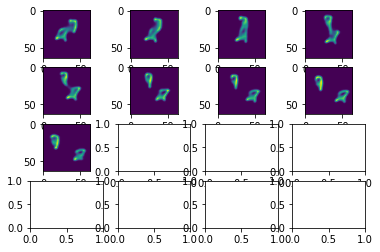

In [17]:
def predict_from_beginning(prev):
    
    hidden = None
    output = None

    for image in prev:
            # forward compute the image
        hidden_prev = hidden
        output, hidden = model(image, hidden)
        
        
    results = torch.zeros(20, prev.shape[1], prev.shape[2], prev.shape[3], prev.shape[4])
    results[0,: ,:, :, :] = output
        
    for i in range(19):
        results[i+1, :,:, :, :], hidden = model(results[i, :,:, :, :], hidden)
        
    return results

images = next(iter(data_loader))

pred = predict(torch.unsqueeze(images[0],1), torch.unsqueeze(images[1],1))

fig, axs = plt.subplots(4,4)
for i in range(9):
    axs[int(i/4), i%4].imshow(pred[i, 0,0 , :, :].detach().numpy())
    
    

    



# Construction of the Diffusion Model
This model will predict the difference between the residual and the true value, correcting our estimation errors.

    * We will be augmenting an open source Diffusion Model